# Results Analysis

`EP3.75` is the case where the average LMP price is $0.0375/kWh

`GC_0` is the no grid charging case where:
 - Battery only charges from PV
 - PV and Battery both receive ITC of 22%
 - Wind does not receive PTC
 
`GC_1` is the grid charging case where:
 - Battery charges from PV, Wind and Grid
 - PV receives ITC of 22%
 - Battery receives no ITC
 - Wind receives PTC of $0.015/kWh

In [20]:
# %matplotlib notebook
# import mpld3
# mpld3.enable_notebook()
import os
from pathlib import Path
import sys

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)
os.chdir(workbookDir)

sys.path.append("/Users/dguittet/Projects/HybridSystems/HOPP")
sys.path.append("/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos")

import pandas as pd
import os
import re
import sys
import json
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from math import *

from cycler import cycler

import json_lines # https://github.com/TeamHG-Memex/json-lines

from IPython.display import display, HTML


from matplotlib.animation import (
    PillowWriter,
    )
from matplotlib.lines import Line2D
from pylab import rcParams

from hybrid.sites import SiteInfo

from tools.optimization import setup_run, NullDataRecorder


font = {'family' : 'monospace',
        'weight' : 'medium',
        'size'   : 19}
plt.rc('font', **font)

rcParams['lines.linewidth'] = 1

wind_color = (153 / 255, 142 / 255, 195 / 255)
solar_color = (241 / 255, 163 / 255, 64 / 255)
batt_color = (65 / 255, 121 / 255, 251 / 255)
flicker_color = (27/255, 158 / 255, 119 / 255)

colors = [
    (67 / 255, 185 / 255, 169 / 255),
    (223 / 255, 142 / 255, 195 / 255),
    (86 / 255, 163 / 255, 64 / 255),
    (165 / 255, 121 / 255, 251 / 255),
    (127 / 255, 58/255, 119/255)
]


directory = Path('/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos')
resource_dir = directory / "resource_files"
params_dir = directory / "parameter_files"
results_dir = directory / "results"

workbookDir: /Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results


# Explore the Inputs

Using normalized cost data that is then scaled by an average price: .0375, 0.04, 0.0425 $/kWh

0.9998858447488584

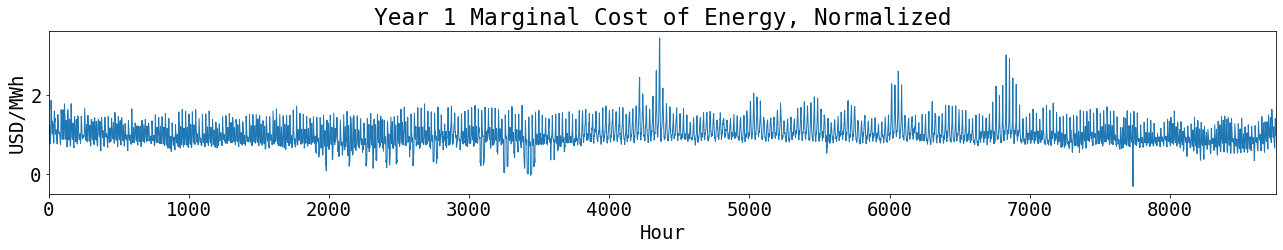

In [2]:
prices = np.loadtxt(resource_dir / "pricing-data-2015-IronMtn-002_factors.csv", skiprows=1)
fig = plt.figure(figsize=(22, 3))
plt.plot(prices[0:8760])
plt.ylabel("USD/MWh")
plt.xlabel("Hour")
plt.xlim((0, 8760))
plt.title("Year 1 Marginal Cost of Energy, Normalized")
len(prices) / 8760

In [21]:
from pathlib import Path
from optimize_npv import HybridLayoutProblem, WindBoundaryGridParameters, PVGridParameters, module_power, simulation_options
from hybrid.sites import make_irregular_site
from hybrid.dispatch.plot_tools import plot_battery_output, plot_battery_dispatch_error, plot_generation_profile

solution_vars = ["border_spacing", "border_offset", "grid_angle", "grid_aspect_power", "row_phase_offset", "num_turbines_ratio_max", "solar_x_position", "solar_y_position", "solar_aspect_power", "solar_gcr", "solar_s_buffer", "solar_x_buffer", "solar_ratio_of_max_mw", "battery_ratio_of_max_mw"]
location = (32.4386, -99.7336, 0)

def create_hybrid_plant():
    solar_file = resource_dir / "32.43861838431444__-99.73363995829895_32.438818_-99.734703_psm3_60_2013.csv"
    wind_file = resource_dir / "lat32.43_lon-99.73__2013_120m.srw"
    prices_file = resource_dir / "pricing-data-2015-IronMtn-002_factors.csv"
    site = SiteInfo(make_irregular_site(lat=location[0], lon=location[1], elev=location[2]),
                    solar_resource_file=solar_file,
                    wind_resource_file=wind_file,
                    grid_resource_file=prices_file)
    
    with open(params_dir / "pv_parameters.json", 'r') as f:
        pv_info = json.load(f)["SystemDesign"]
    with open(params_dir / "wind_parameters.json", 'r') as f:
        wind_info = json.load(f)
    turb_rating_kw = max(wind_info['Turbine']['wind_turbine_powercurve_powerout'])
    with open(params_dir / "financial_parameters.json", 'r') as f:
        fin_info = json.load(f)
    cost_info = fin_info['capex']
    fin_info["Revenue"]["ppa_price_input"] = (4 * 0.01,)
        
    problem = HybridLayoutProblem(site_info=site, cost_config=dict(), sim_config=simulation_options, dispatch_config=dispatch_options, 
                                  turb_size_kw=6000, pv_config=pv_info, wind_config=wind_info,
                                  fin_config=fin_info)
    return problem

problem = create_hybrid_plant()

bounds = problem.site.polygon.bounds
site_sw_bound = np.array([bounds[0], bounds[1]])
site_ne_bound = np.array([bounds[2], bounds[3]])
site_center = .5 * (site_sw_bound + site_ne_bound)
max_delta = max(bounds[2] - bounds[0], bounds[3] - bounds[1])
reach = (max_delta / 2) * 1.3
min_plot_bound = site_center - reach
max_plot_bound = site_center + reach

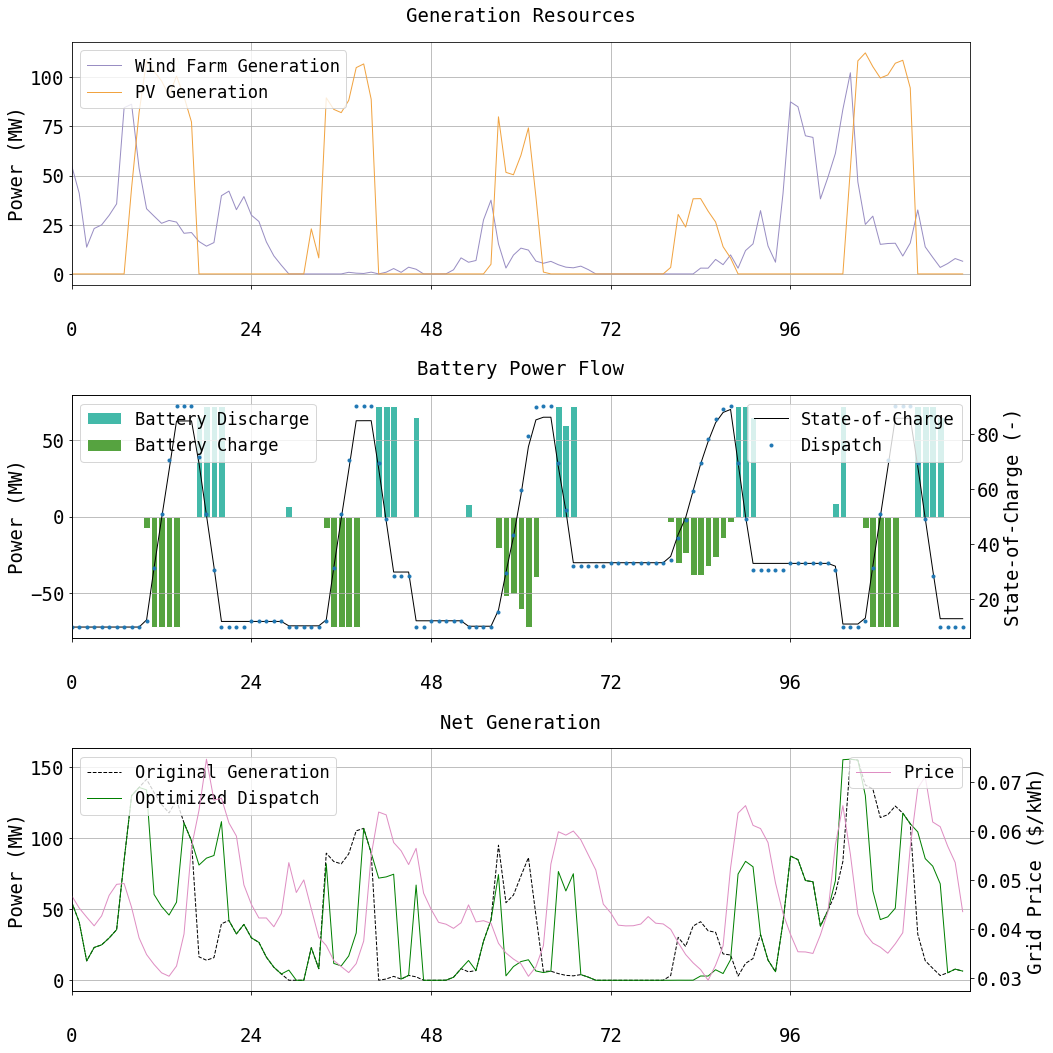

In [22]:
dispatch_options = {
        'battery_dispatch': 'simple',
        # 'battery_dispatch': 'one_cycle_heuristic',
        'grid_charging': False,
        'pv_charging_only': True,
        'log_name': ""  # need to disable for multiprocessing
    }

plant = problem._set_simulation_to_candidate([4.277015828506016, 0.509881631963763, 3.141592653589793, -0.40524681412724906, 0.7701112115225583, 0.43899912717548045, 0.7327013641802729, 0.7623341353643145, -1.412184634371493, 0.3149578925279668, 4.3186975957964275, 0.9843775997683757, 0.6077832173974904, 0.3])
plant.simulate(1)
gen = plant.generation_profile

plot_generation_profile(plant, font_size=19, wind_color=wind_color, solar_color=solar_color, 
                        discharge_color=colors[0], charge_color=colors[2], price_color=colors[1])

# Plot Grid Search Results with No Layout

### Each of these 3D grids are created by simulating the hybrid plant performance and NPV without adding boundary constraints and wake losses. Instead, the turbines are only determined by the desired system capacity and the wake losses are fixed to 5%. This will result in overestimation of the optimal capacity of wind and pv.

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV
Max NPV of -0.8217406027660668 with 1 PV, 6 Wind and 0 Battery


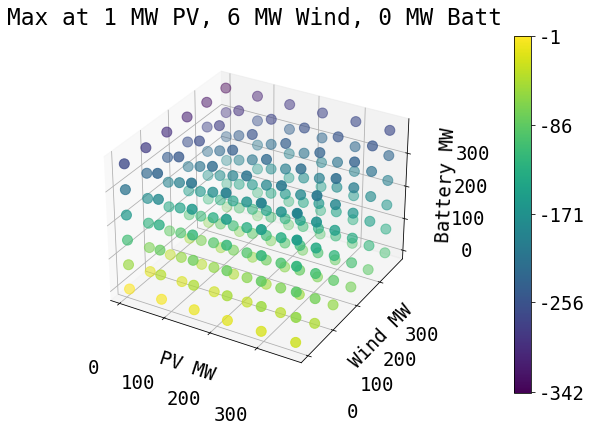

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4_GC_1_NPV
Max NPV of 129.2421343414403 with 1 PV, 366 Wind and 0 Battery


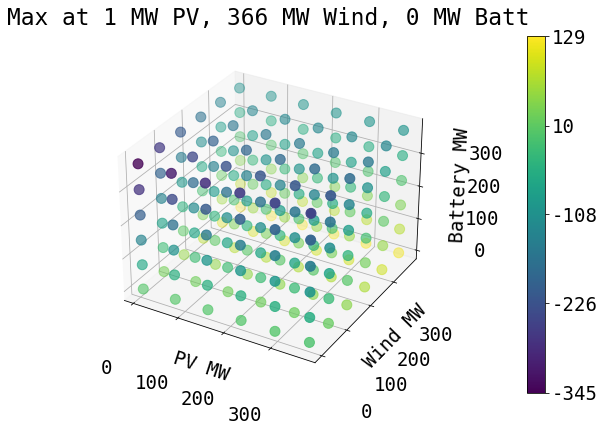

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4_GC_0_NPV
Max NPV of -0.0743910264149811 with 1 PV, 6 Wind and 0 Battery


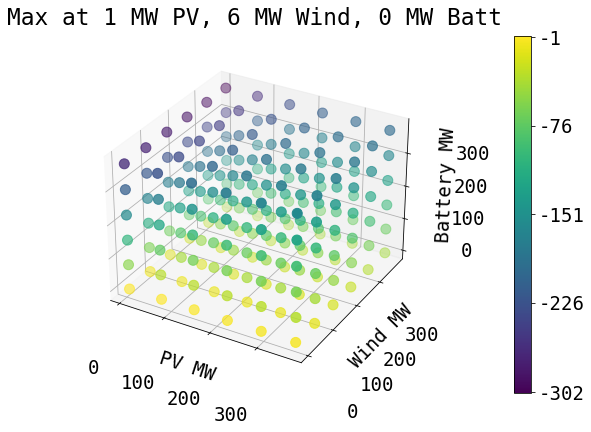

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_1_NPV
Max NPV of 89.19620451360296 with 1 PV, 366 Wind and 0 Battery


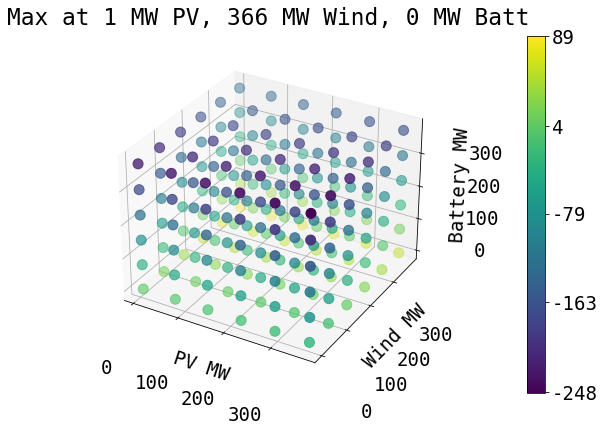

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_NPV
Max NPV of 19.581865871880293 with 376 PV, 366 Wind and 0 Battery


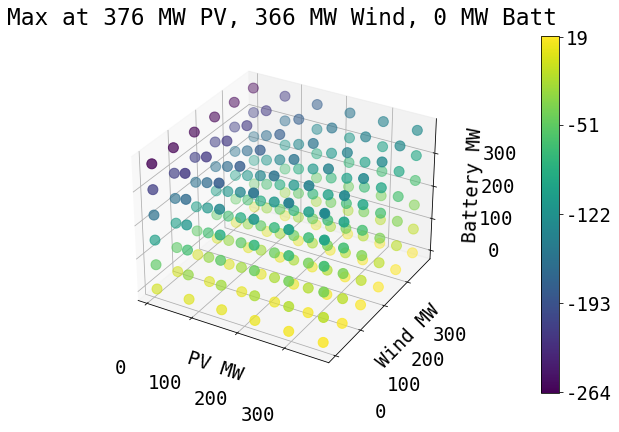

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_1_NPV
Max NPV of 180.22355113002158 with 376 PV, 366 Wind and 0 Battery


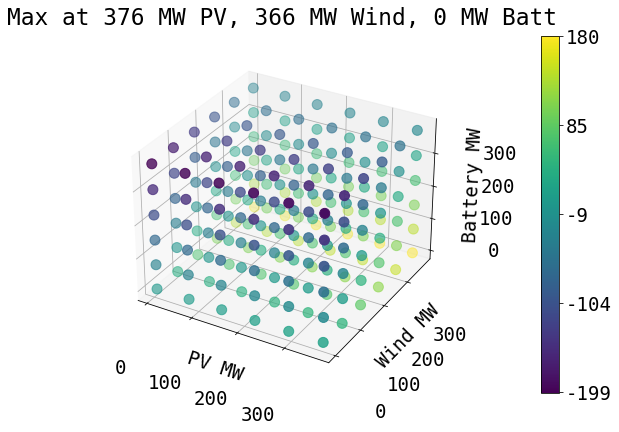

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4_GC_0_CAP
Max NPV of -0.0743910264149811 with 1 PV, 6 Wind and 0 Battery


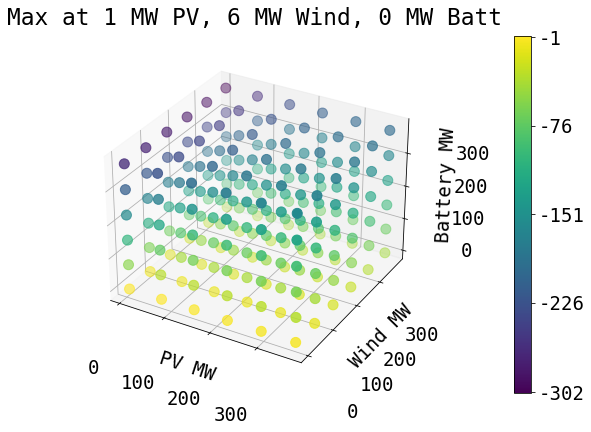

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_CAP
Max NPV of -0.8217406027660668 with 1 PV, 6 Wind and 0 Battery


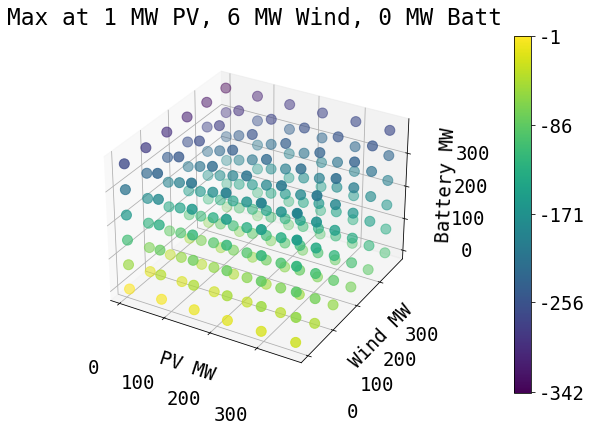

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_CAP
Max NPV of 19.581865871880293 with 376 PV, 366 Wind and 0 Battery


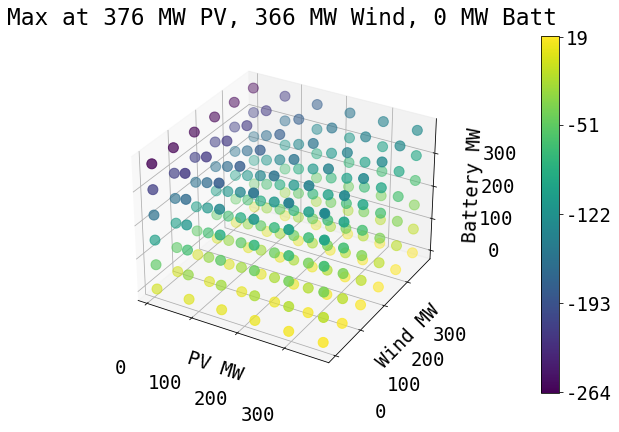

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import glob

rcParams['figure.figsize'] = 8, 12
rcParams['axes.titlepad'] = 20 
rcParams['xtick.major.pad']='32'

def plot_grid(output_file):
    output_res = json.load(open(output_file, "r"))
    # Max NPV coordinates 1 366 375 172659761.8127966
    # organize data

    X = []  # solar
    Y = []  # wind
    Z = []  # battery
    NPV = []
    AEP = []
    REV = []
    CAP_PV = []
    for i in output_res:
        X.append(i[0][0])
        Y.append(i[0][1])
        Z.append(i[0][2])
        AEP.append(json.loads(i[1])['hybrid'])
        npv = json.loads(i[-2])['hybrid']
        if npv < -1e37:
            npv = min(NPV)
        NPV.append(npv)
        REV.append(json.loads(i[3])['hybrid'])
        CAP_PV.append(json.loads(i[2])['pv'])
    x_inds = sorted(list(set(X)))
    y_inds = sorted(list(set(Y)))
    z_inds = sorted(list(set(Z)))
    Xs, Ys, Zs = np.meshgrid(x_inds, y_inds, z_inds)
    NPVs = np.zeros(Xs.shape)
    AEPs = np.zeros(Xs.shape)
#     print("PV, Wind, Batt, NPV (mil)")
    for i in output_res:
        x = i[0][0]
        y = i[0][1]
        z = i[0][2]
        x_ind = x_inds.index(x)
        y_ind = y_inds.index(y)
        z_ind = z_inds.index(z)
        aep = json.loads(i[1])['hybrid']
        npv = json.loads(i[-2])['hybrid']
        cf = json.loads(i[2])
        if npv < -1e37:
            npv = min(NPV)
        NPVs[y_ind, x_ind, z_ind] = npv * 1e-6
        AEPs[y_ind, x_ind, z_ind] = aep

    # get max NPV
    max_ind = int(np.argmax(NPV))
    print(Path(output_file).parent)
    print(f"Max NPV of {NPV[max_ind] * 1e-6} with {X[max_ind]} PV, {Y[max_ind]} Wind and {Z[max_ind]} Battery")

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.plot_trisurf(X, Y, Z, edgecolor="gray", color="None")
    img = ax.scatter(Y, X, Z, c=NPVs, s=100)
    # ax.scatter( X[max_ind], Y[max_ind], Z[max_ind], s=320, marker='*', color='tomato')
    ax.set_xlabel("PV MW")
    ax.set_ylabel("Wind MW")
    ax.set_zlabel("Battery MW")
    cbar = fig.colorbar(img, fraction=0.04, pad=0.2)
    m0 = int(np.ceil(NPVs.min()))            # colorbar min value
    m4 = int(np.floor(NPVs.max()))             # colorbar max value
    m1 = int(1 * (m4-m0) / 4.0 + m0)               # colorbar mid value 1
    m2 = int(2 * (m4-m0) / 4.0 + m0)               # colorbar mid value 2
    m3 = int(3 * (m4-m0) / 4.0 + m0)               # colorbar mid value 3
    cbar.set_ticks([m0, m1, m2, m3, m4])
    cbar.set_ticklabels([m0, m1, m2, m3, m4])
#     plt.suptitle(f"Grid of NPVs in $M")
    plt.title(f"Max at {X[max_ind]} MW PV, {Y[max_ind]} MW Wind, {Z[max_ind]} MW Batt")
    plt.savefig(Path(output_file).parent / "grid_view.png")
    plt.show()

for f in glob.glob(str(results_dir / "*" / "*grid.json")):
    plot_grid(f)

# Plot Optimal Layouts

### Now go through the optimal sizing with layout and boundary constraints: adding flicker, wake losses

Due to randomness in the optimization algorithm, each folder's configuration was run 3 times to see a multiple of optimal results.

In [54]:
# print(os.listdir('.'))
# print(os.path.dirname(os.path.realpath('.')))

def load_results(path, run_group, index='iteration'):
#     run_name_extractor = re.compile(r'^(.*)_(\d\d\d\d\-\d\d\-\d\dT\d\d\.\d\d\.\d\d\.\d+)$')
    run_name_extractor = re.compile(r'^(.*)_([^_]+)$')
    
    dirs = [f for f in os.listdir(path)]
#     print(dirs)
    data_sets = {}
    for d in dirs:
        
        dir_path = os.path.join(path, d)
#         print(dir_path)
        if '.jsonl' not in dir_path:
            continue
            
        if 'copy' in dir_path:
            continue
    
        f = os.path.join(dir_path)
        
        columns = []
        data = None
        with open(f, 'rb') as file:
#             print(f)
            columns = next(json_lines.reader(file))

            data_set = pd.DataFrame(json_lines.reader(file), columns = columns)

        data_set.set_index(index, inplace=True)
        
        run_name = f.split('/')[-1].split('.log')[0]
#         print(run_name)
        
        if run_group not in data_sets:
            data_sets[run_group] = {}
        run_data_sets = data_sets[run_group]
        run_data_sets[run_name] = data_set
        
    return data_sets

def make_aggregated_data_set(data_sets):
    aggregated_data_sets = {}
    for run_group, runs in data_sets.items():
        group_data = {}
        for run_name, data_set in runs.items():
            for column in data_set.columns:
                if column not in group_data:
                    group_data[column] = pd.DataFrame()
                group_data[column][run_name] = data_set[column]
        aggregated_data_sets[run_group] = group_data
    return aggregated_data_sets


def extract_solution_vars(data_sets, solution_vars, solution_name = 'best_solution'):
    for run_group, runs in data_sets.items():
        for run_name, data_set in runs.items():
            solutions = data_set[solution_name]
            if solution_vars is None:
                solution_vars = sorted(solutions.iloc[0].keys())
            for n, var in enumerate(solution_vars):
                data_set[solution_name + '.' + var] = [row[n] for row in solutions]
    return solution_vars

def unpack_solution_vars(data_sets, solution_vars, solution_name):
    for run_group, runs in data_sets.items():
        for run_name, data_set in runs.items():
            solutions = data_set[solution_name]
            for i, var in enumerate(solution_vars):
                data_set[solution_name + '.' + var] = [row[i] for row in solutions]
            
def load_and_preprocess(directory, run_name):
    data_sets = load_results(directory, run_name)
#     print('data_sets', data_sets)
    extract_solution_vars(data_sets, solution_vars)
    unpack_solution_vars(data_sets, solution_vars, 'mean')
    unpack_solution_vars(data_sets, solution_vars, 'variance')
    aggregated_data_sets = make_aggregated_data_set(data_sets)

#     for j, (run_group, group_data) in enumerate(aggregated_data_sets.items()):
#         print(run_group)
    return data_sets, aggregated_data_sets, solution_vars


In [34]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# plt.style.use('seaborn-whitegrid')
plt.ion()

rcParams['lines.linewidth'] = 4

solar_max_mw = 300
turbines_max = 62
battery_max_mw = 300
def plot_site(candidate, min_plot_bound, max_plot_bound, site_fig_size, title):

    site_border_color = (0, 0, 0)
    fig, ax = plt.subplots(1, figsize=site_fig_size)
    ax.axis('scaled')
    ax.set(xlim=(min_plot_bound[0], max_plot_bound[0]), ylim=(min_plot_bound[1], max_plot_bound[1]))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    ax.margins(y=0, x=0)
    
    problem = create_hybrid_plant()
    simulation = problem._set_simulation_to_candidate(candidate)
    simulation.site.plot(fig, ax, site_border_color)
    simulation.layout.plot(fig, ax,
                           wind_color=wind_color,
                           pv_color=solar_color,
                           site_border_color=site_border_color,
                           alpha=1)
    
    plt.tight_layout()
    wind_mw = simulation.wind.num_turbines * 6 if simulation.wind.num_turbines > 1 else 0
    solar_mw = simulation.pv.system_capacity_kw * 1e-3
    batt_mw = simulation.battery.system_capacity_kw * 1e-3
    plt.title(f"{round(wind_mw)} MW Wind, {round(solar_mw)} MW Solar, {round(batt_mw)} MW Battery")
    plt.suptitle(title)
    plt.margins(0,0)
    plt.show()

    return fig
    
def plot_sites(runs, group_name, site_fig_size):
    ds = None
    for j, (run_name, data_set) in enumerate(runs.items()):
        if run_name == "README":
            continue
        ds = data_set
        json_candidate = data_set.at[len(data_set.index)-1, 'best_solution']
        evaluation = data_set.at[len(data_set.index)-1, 'best_evaluation']
        title = f"Best NPV ${round(evaluation * 1e-6, 2)}M"
        fig = plot_site(json_candidate, min_plot_bound, max_plot_bound, site_fig_size, title)
        score = data_set.at[len(data_set.index)-1, 'best_score']
        baseline_value = data_set.at[data_set.index[0], 'best_score']

        print(json_candidate, score, evaluation, run_name)

#         plt.label(str(evaluation / 1e3) + 'GWh AEP')
#         plt.savefig(group_name + '_' + str(j) + '_layout.svg')
        fig.savefig(results_dir / "fig_layout.png")
#         fig2.savefig(group_name + '_' + str(j) + '_stats.svg')
    
    return json_candidate, evaluation, score, baseline_value

In [26]:

def smooth_aggregated_column(aggregated_column, window_size):
    print('ws ', window_size)
    return aggregated_column.rolling(window=window_size,axis=0).mean()

def plot_quantile(ax, x, aggregated_column, color=(0,0,.8), alpha=.25, value=.5):
    q1 = aggregated_column.quantile(.5+value/2, 1).values.tolist()
    q2 = aggregated_column.quantile(.5-value/2, 1).values.tolist()
    ax.fill_between(x, q1, q2, color=(*color, alpha))

def plot_quantiles(ax, x, aggregated_column, color=(0,0,.8), alpha=.5, value=.5):
#     plot_quantile(ax, x, aggregated_column, color, alpha, value)
    plot_quantile(ax, x, aggregated_column, color, alpha * .5, value * 2)
    ax.plot(x, aggregated_column.quantile(.5, 1), color=color)

def plot_smooth_quantiles(x, aggregated_column, window_size=5, **kwargs):
    plot_quantiles(x, smooth_aggregated_column(aggregated_column, window_size), **kwargs)
    
def normalize_sequence(seq):
    hi = max(seq)
    lo = min(seq)
    scale = max(1e-6, hi - lo)
    return [(x-lo) / scale for x in seq]


def setup_minor_ticks(ax):
    ax.minorticks_on()
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=4)

def plot_perf(aggregated_data_sets, baseline_value, ordering, figsize=(10,8)):
    def aep_to_pct(x):
        return x * 1e-6

    def gwh_to_pct(x):
        return x

    def pct_to_gwh(y):
        return y

    fig, ax = plt.subplots(1, figsize=figsize)
    
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    setup_minor_ticks(ax)

    ax.minorticks_on()

    plt.ylabel('NPV ($mil)')
    plt.xlabel('# of candidates evaluated')
    
    labels = []
        
    for i, run_group in enumerate(ordering):
        run_data = aggregated_data_sets[run_group]
        scores = run_data['best_evaluation']
        pct = aep_to_pct(scores)
        plot_quantiles(ax, run_data['num_evaluations'].median(1) + 200, pct, color=colors[i%len(colors)])
        labels.append(run_group)
        
#         print(scores.mean(1).values[-1])
        print('{} mean {} stdev {} median {}\n'.format(run_group, pct.mean(1).values[-1], pct.std(1).values[-1], pct.median(1).values[-1]))
    
    return fig, ax, None


## Load the Data

Collect the 3 trials per run configuration

In [55]:
runs = ("EP3.75_GC_0_NPV", "EP3.75_GC_1_NPV", "EP4_GC_0_NPV", "EP4_GC_1_NPV", "EP4.25_GC_0_NPV", "EP4.25_GC_1_NPV", "EP3.75_GC_0_CAP", "EP4_GC_0_CAP", "EP4.25_GC_0_CAP", )
# runs = ["25_GC_0_NPV"]
aggregated_data_sets = dict()
data_sets = dict()
for r in runs:
    data_set, aggregated_data_set, _ = load_and_preprocess(results_dir / r, r)
    data_set[r]['README'] = json.load(open(results_dir / r / "README.json"))
    aggregated_data_sets.update(aggregated_data_set)
    data_sets.update(data_set)
aggregated_data_sets.keys()


dict_keys(['EP3.75_GC_0_NPV', 'EP3.75_GC_1_NPV', 'EP4_GC_0_NPV', 'EP4_GC_1_NPV', 'EP4.25_GC_0_NPV', 'EP4.25_GC_1_NPV', 'EP3.75_GC_0_CAP', 'EP4_GC_0_CAP', 'EP4.25_GC_0_CAP'])

In [40]:
print(data_sets['EP4.25_GC_1_NPV']['results']['best_score'].values[-1],
data_sets['EP4.25_GC_1_NPV']['results']['best_solution'].values[-1])
print(data_sets['EP4.25_GC_0_CAP']['results'].keys())

68642942.57442318 [4.338331278383588, 1.0, 2.2847410450721384, -1.5020270100304263, 0.4314798720741066, 0.40422933350422746, 0.43442972376269473, 0.29728701894024134, -0.8442128884366926, 0.1, 4.307520979142147, 6.673602438041312, 0.8401779574432586, 0.03855903447028586]
Index(['generation', 'mean', 'variance', 'covariance', '_sigma', '_p_c',
       '_p_sigma', 'num_evaluations', 'best_score', 'best_evaluation',
       'best_solution', 'best_solution.border_spacing',
       'best_solution.border_offset', 'best_solution.grid_angle',
       'best_solution.grid_aspect_power', 'best_solution.row_phase_offset',
       'best_solution.num_turbines_ratio_max',
       'best_solution.solar_x_position', 'best_solution.solar_y_position',
       'best_solution.solar_aspect_power', 'best_solution.solar_gcr',
       'best_solution.solar_s_buffer', 'best_solution.solar_x_buffer',
       'best_solution.solar_ratio_of_max_mw',
       'best_solution.battery_ratio_of_max_mw', 'mean.border_spacing',
      

## Explore Results with both Wind and Solar Tax Incentives, Battery charging from Grid, Solar and Wind

{'energy_price_base': 3.75, 'grid_charging': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.015], 'location': 'TX'}


Could not fit 8121.942000000001 kw into existing PV layout parameters of PVGridParameters(x_position=0.9195340392900184, y_position=0.5694651440569067, aspect_power=-4.0, gcr=0.1, s_buffer=1.0518108704659372, x_buffer=7.400017932035946)


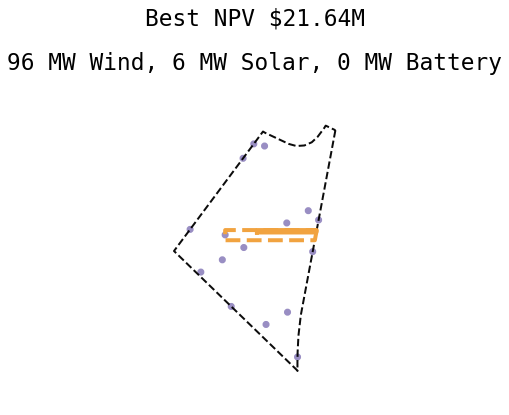

[13.089053753835184, 0.8566356533379924, 2.622427626160114, 1.145761069608162, 0.7627092044631634, 0.6736951829449322, 0.9195340392900184, 0.5694651440569067, -4.0, 0.1, 1.0518108704659372, 7.400017932035946, 0.027073384206113604, 0.0009795099558542186] 21635348.035176724 21635353.99742967 results
[13.089053753835184, 0.8566356533379924, 2.622427626160114, 1.145761069608162, 0.7627092044631634, 0.6736951829449322, 0.9195340392900184, 0.5694651440569067, -4.0, 0.1, 1.0518108704659372, 7.400017932035946, 0.027073384206113604, 0.0009795099558542186] 21635353.99742967 21635348.035176724 -30406080.892085925


In [41]:
current_run = run_group = 'EP3.75_GC_1_NPV'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)
print(best_solution, evaluation, score, baseline_value)

{'energy_price_base': 4, 'grid_charging': 0, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.015], 'location': 'TX'}


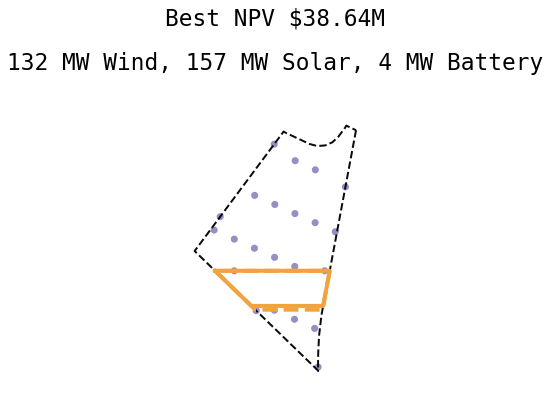

[10.950127125539703, 0.6370711444528725, 1.0573443749932898, -1.8303655458066812, 0.21850657142936702, 0.364195920552846, 0.7898813156999299, 0.3368636754165076, -4.0, 0.1, 0.0, 4.430228265371239, 0.5242025550374775, 0.012968082495838293] 38636732.33941146 38636783.396837056 results
[10.950127125539703, 0.6370711444528725, 1.0573443749932898, -1.8303655458066812, 0.21850657142936702, 0.364195920552846, 0.7898813156999299, 0.3368636754165076, -4.0, 0.1, 0.0, 4.430228265371239, 0.5242025550374775, 0.012968082495838293] 38636783.396837056 38636732.33941146 -328458.0122326513


In [42]:
current_run = run_group = 'EP4_GC_1_NPV'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)
print(best_solution, evaluation, score, baseline_value)

{'energy_price_base': 4.25, 'grid_charging': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.015], 'location': 'TX'}


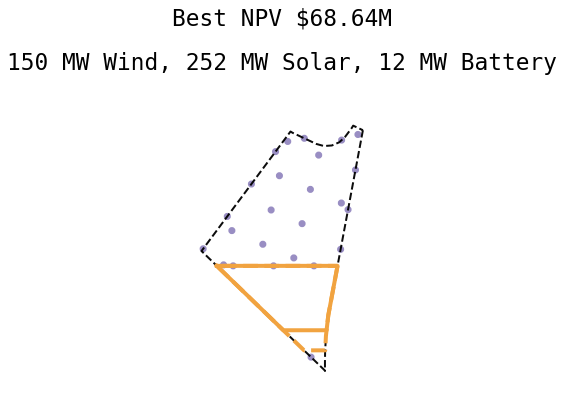

[4.338331278383588, 1.0, 2.2847410450721384, -1.5020270100304263, 0.4314798720741066, 0.40422933350422746, 0.43442972376269473, 0.29728701894024134, -0.8442128884366926, 0.1, 4.307520979142147, 6.673602438041312, 0.8401779574432586, 0.03855903447028586] 68642942.57442318 68642987.17967963 results
[4.338331278383588, 1.0, 2.2847410450721384, -1.5020270100304263, 0.4314798720741066, 0.40422933350422746, 0.43442972376269473, 0.29728701894024134, -0.8442128884366926, 0.1, 4.307520979142147, 6.673602438041312, 0.8401779574432586, 0.03855903447028586] 68642987.17967963 68642942.57442318 8132020.189947034


In [43]:
current_run = run_group = 'EP4.25_GC_1_NPV'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)
print(best_solution, evaluation, score, baseline_value)

8132020.189947034
EP3.75_GC_1_NPV mean 21.635353997429668 stdev nan median 21.635353997429668

EP4_GC_1_NPV mean 38.63678339683705 stdev nan median 38.63678339683705

EP4.25_GC_1_NPV mean 68.64298717967962 stdev nan median 68.64298717967962



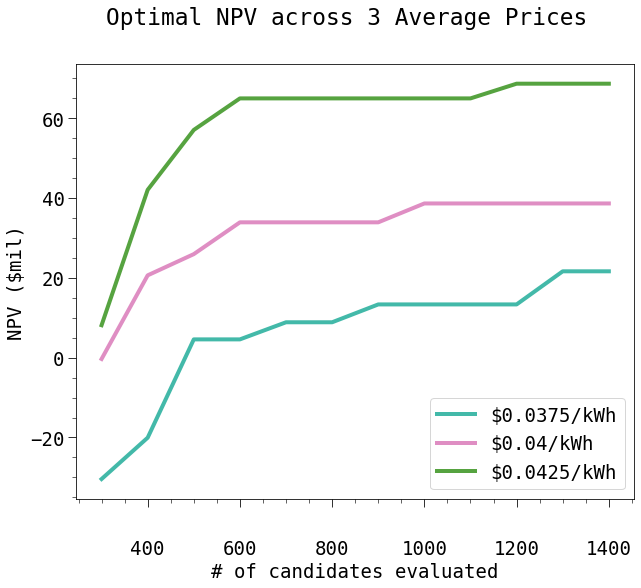

8132020.189947034


In [44]:
ordering = ['EP3.75_GC_1_NPV', 'EP4_GC_1_NPV', 'EP4.25_GC_1_NPV']
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["$0.0375/kWh", "$0.04/kWh", "$0.0425/kWh"], loc='lower right')

plt.suptitle("Optimal NPV across 3 Average Prices")
plt.show()
print(baseline_value)

## Explore Results with only Solar & Battery Tax Incentives

{'energy_price_base': 3.75, 'grid_charging': 0, 'pv_charging_only': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.0], 'location': 'TX'}


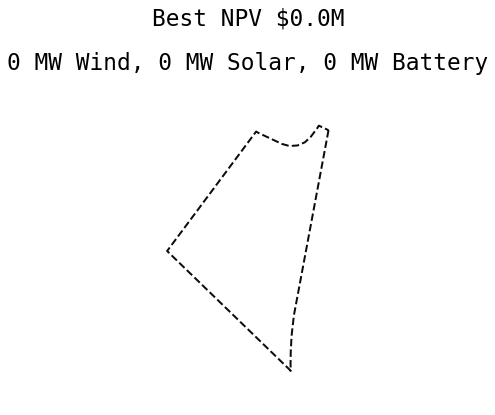

[11.133498176351123, 0.9492847057893883, 0.9280098121206002, 0.4354689794637374, 1.0, 0.0, 0.8115168800603482, 0.393006081700174, -1.8987724641007167, 0.7206604007101096, 6.5928711580391735, 7.937754761389517, 0.0, 0.0] -0.008512332938403946 0.0 results
[11.133498176351123, 0.9492847057893883, 0.9280098121206002, 0.4354689794637374, 1.0, 0.0, 0.8115168800603482, 0.393006081700174, -1.8987724641007167, 0.7206604007101096, 6.5928711580391735, 7.937754761389517, 0.0, 0.0] 0.0 -0.008512332938403946 -52512110.45785992


In [45]:
current_run = run_group = 'EP3.75_GC_0_NPV'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)
print(best_solution, evaluation, score, baseline_value)

{'energy_price_base': 4, 'grid_charging': 0, 'pv_charging_only': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.0], 'location': 'TX'}


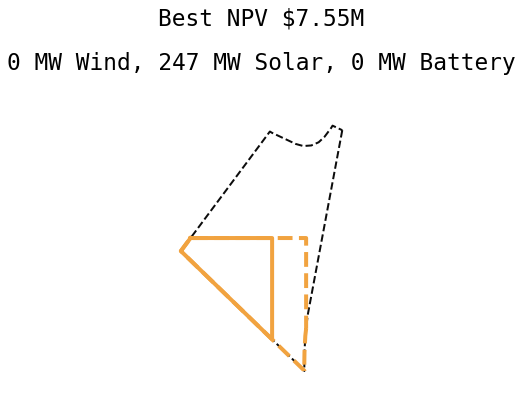

[6.983985397450944, 0.8055661167241684, 0.0, 1.7783091430411113, 0.7486059609214213, 0.0, 0.0, 0.1060988981504099, 0.15868374323303572, 0.1, 7.717893176214386, 7.991001004276951, 0.824970151551935, 0.00032697746704583256] 7554135.102193246 7554197.500238895 results
[6.983985397450944, 0.8055661167241684, 0.0, 1.7783091430411113, 0.7486059609214213, 0.0, 0.0, 0.1060988981504099, 0.15868374323303572, 0.1, 7.717893176214386, 7.991001004276951, 0.824970151551935, 0.00032697746704583256] 7554197.500238895 7554135.102193246 -48683532.97453544


In [46]:
current_run = run_group = 'EP4_GC_0_NPV'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)
print(best_solution, evaluation, score, baseline_value)

{'energy_price_base': 4.25, 'grid_charging': 0, 'pv_charging_only': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.0], 'location': 'TX'}


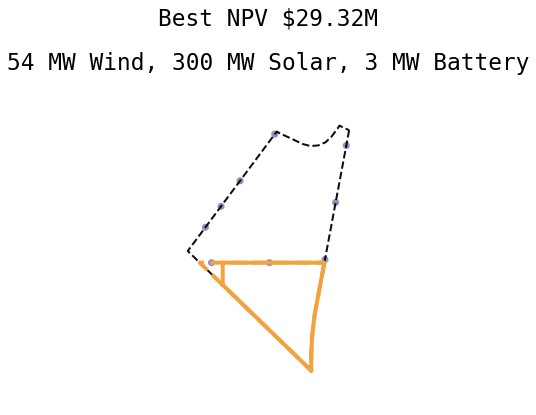

[6.668898285389989, 0.2667479500819712, 3.141592653589793, 1.2467727580680057, 0.38554307109486374, 0.1485446475981471, 0.5367749167505199, 0.13926477866524764, 0.3610686792864124, 0.1, 0.0, 7.327814085916537, 1.0, 0.010245800930107449] 29315707.661247123 29315768.70878321 results
[6.668898285389989, 0.2667479500819712, 3.141592653589793, 1.2467727580680057, 0.38554307109486374, 0.1485446475981471, 0.5367749167505199, 0.13926477866524764, 0.3610686792864124, 0.1, 0.0, 7.327814085916537, 1.0, 0.010245800930107449] 29315768.70878321 29315707.661247123 -13844485.846713472


In [47]:
current_run = run_group = 'EP4.25_GC_0_NPV'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)
print(best_solution, evaluation, score, baseline_value)

-13844485.846713472
EP3.75_GC_0_NPV mean 0.0 stdev nan median 0.0

EP4_GC_0_NPV mean 8.57733048121202 stdev nan median 8.57733048121202

EP4.25_GC_0_NPV mean 29.315768708783207 stdev nan median 29.315768708783207



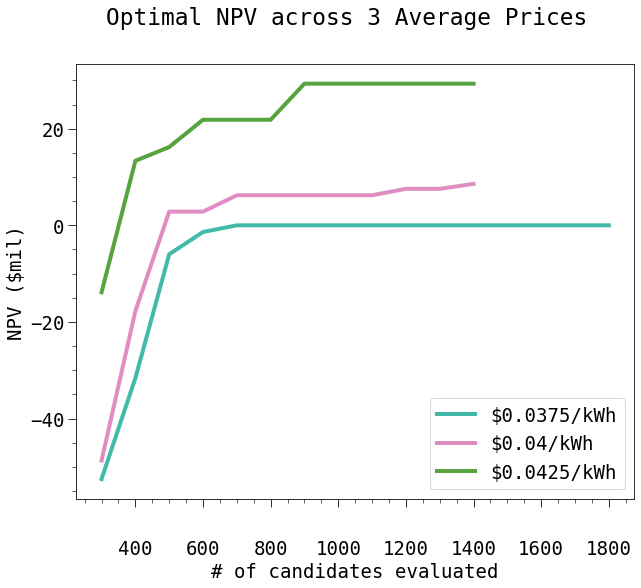

-13844485.846713472


In [48]:
ordering = ['EP3.75_GC_0_NPV', 'EP4_GC_0_NPV', 'EP4.25_GC_0_NPV']
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["$0.0375/kWh", "$0.04/kWh", "$0.0425/kWh"], loc='lower right')

plt.suptitle("Optimal NPV across 3 Average Prices")
plt.show()
print(baseline_value)

## Explore Results with only Solar & Battery Tax Incentives, Higher Capacity Payment

{'energy_price_base': 3.75, 'grid_charging': 0, 'pv_charging_only': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.0], 'location': 'TX', 'cp_capacity_payment_amount': 75000}


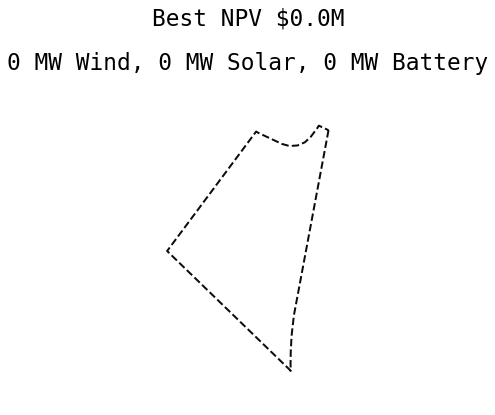

[16.041897426446187, 0.17185405211992652, 1.0251616899555198, -2.3866631963939886, 0.6555061055660628, 0.0, 0.40104562870688343, 0.5373375039821406, 1.6474912128953267, 0.375714678827195, 2.939410036824334, 4.4387079710740505, 0.0, 0.0] -0.0032683473273461185 0.0 results


In [49]:
current_run = run_group = 'EP3.75_GC_0_CAP'
runs = data_sets[run_group]
site_fig_size = (5,7)
print(runs['README'])
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)


{'energy_price_base': 4, 'grid_charging': 0, 'pv_charging_only': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.0], 'location': 'TX', 'cp_capacity_payment_amount': 75000}


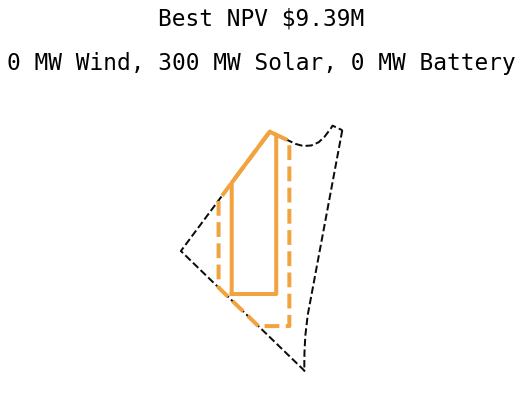

[12.357314400602949, 0.6466942151542783, 1.9138140094375489, -0.03969551244789199, 0.8577590015039762, 0.0, 0.45283578088514675, 0.668863902958066, 1.3646715980926358, 0.1, 7.479532194261555, 2.47065463539304, 1.0, 0.0] 9394914.421253756 9394914.441193938 results


In [50]:
current_run = run_group = 'EP4_GC_0_CAP'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)

{'energy_price_base': 4.25, 'grid_charging': 0, 'pv_charging_only': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.0], 'location': 'TX', 'cp_capacity_payment_amount': 75000}


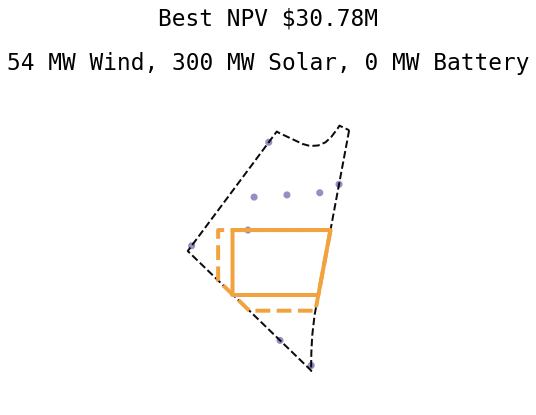

[16.05750857045132, 0.4261388564703716, 1.8336612667333023, -0.8984746034099551, 0.86099840324869, 0.15022386684953554, 0.6860487468416161, 0.44211472730234336, -0.7080039502349003, 0.10980034072699538, 3.1477996734957374, 2.8059800760758438, 1.0, 0.0] 30777026.29511949 30777026.407250404 results


In [51]:
current_run = run_group = 'EP4.25_GC_0_CAP'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)

-24832331.629841734
EP3.75_GC_0_CAP mean 0.0 stdev nan median 0.0

EP4_GC_0_CAP mean 9.394914441193938 stdev nan median 9.394914441193938

EP4.25_GC_0_CAP mean 30.777026407250403 stdev nan median 30.777026407250403



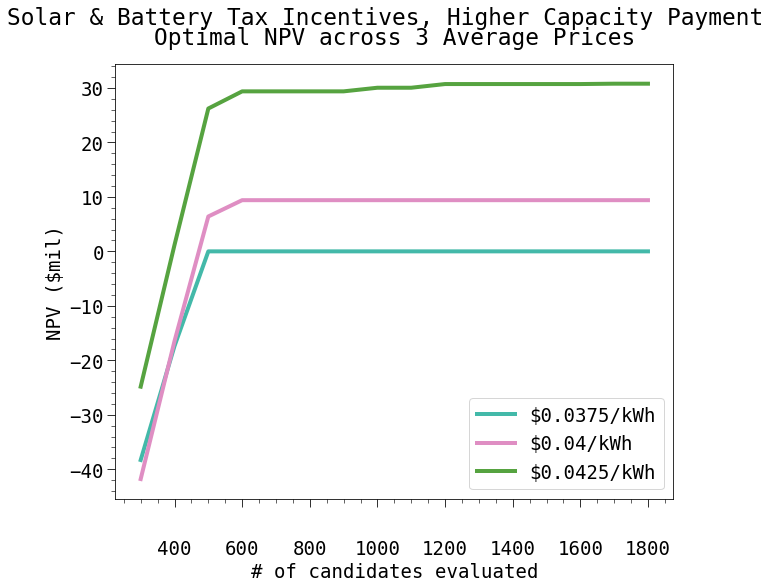

In [52]:
ordering = ['EP3.75_GC_0_CAP', 'EP4_GC_0_CAP', 'EP4.25_GC_0_CAP']
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["$0.0375/kWh", "$0.04/kWh", "$0.0425/kWh"], loc='lower right')

plt.title("Optimal NPV across 3 Average Prices")
plt.suptitle("Solar & Battery Tax Incentives, Higher Capacity Payment")
plt.show()


# Across all 3 Run configurations

-24832331.629841734
EP3.75_GC_0_NPV mean 0.0 stdev nan median 0.0

EP3.75_GC_1_NPV mean 21.635353997429668 stdev nan median 21.635353997429668

EP3.75_GC_0_CAP mean 0.0 stdev nan median 0.0

EP4_GC_0_NPV mean 8.57733048121202 stdev nan median 8.57733048121202

EP4_GC_1_NPV mean 38.63678339683705 stdev nan median 38.63678339683705

EP4_GC_0_CAP mean 9.394914441193938 stdev nan median 9.394914441193938

EP4.25_GC_0_NPV mean 29.315768708783207 stdev nan median 29.315768708783207

EP4.25_GC_1_NPV mean 68.64298717967962 stdev nan median 68.64298717967962

EP4.25_GC_0_CAP mean 30.777026407250403 stdev nan median 30.777026407250403



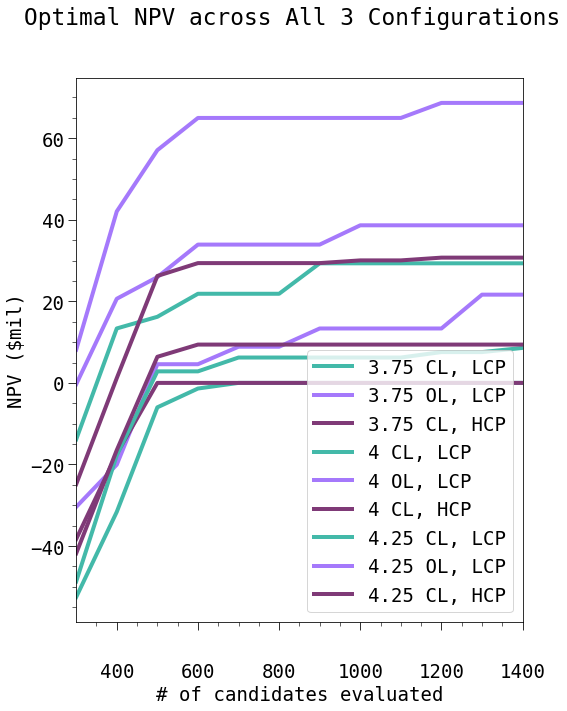

-24832331.629841734


In [72]:
colors = [
    (67 / 255, 185 / 255, 169 / 255),
#     (86 / 255, 163 / 255, 64 / 255),
    (165 / 255, 121 / 255, 251 / 255),
    (127 / 255, 58/255, 119/255)
]
ordering = ('EP3.75_GC_0_NPV', 'EP3.75_GC_1_NPV', 'EP3.75_GC_0_CAP', 'EP4_GC_0_NPV', 'EP4_GC_1_NPV', 'EP4_GC_0_CAP', 'EP4.25_GC_0_NPV',  'EP4.25_GC_1_NPV', 'EP4.25_GC_0_CAP')
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering, (8, 10))
plt.legend(['3.75 CL, LCP', '3.75 OL, LCP', '3.75 CL, HCP', '4 CL, LCP', '4 OL, LCP', '4 CL, HCP', '4.25 CL, LCP',  '4.25 OL, LCP', '4.25 CL, HCP'], loc='lower right')

# ax.set_ylim(3.1, 4.5)
# ax.set_yticks([3.5, 4.0, 4.5])
ax.set_xlim(300, 1400)
# ax.set_xticks([0,10000,20000,30000,40000,50000])
# ax2.set_yticks([219, 220, 221])
plt.suptitle("Optimal NPV across All 3 Configurations")
plt.show()
# plt.savefig(name + 'progress.svg')
print(baseline_value)